## 552 Project

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.datasets.mnist as mnist
import numpy as np

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# k-fold cross validation
from sklearn.model_selection import StratifiedKFold

#### Prepare the dataset

In [17]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Sampling of the training dataset: 600 images for each class
selected_indices_per_class = []
for class_idx in range(len(np.unique(y_train))):
    selected_indices = np.random.choice(np.where(y_train == class_idx)[0], size=600, replace=False)
    selected_indices_per_class.append(selected_indices)

selected_indices = np.concatenate(selected_indices_per_class)
np.random.shuffle(selected_indices)

x_train = x_train[selected_indices]
y_train = y_train[selected_indices]


# Normalization of X
# Find minimum and maximum values
min_val_train = np.min(x_train)
max_val_train = np.max(x_train)

min_val_test = np.min(x_test)
max_val_test = np.max(x_test)

# Linear transformation to normalize data to [0, 1]
normalized_x_train = (x_train - min_val_train) / (max_val_train - min_val_train)
normalized_x_test = (x_test - min_val_test) / (max_val_test - min_val_test)


In [18]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(normalized_x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(normalized_x_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
x_train_resized = F.interpolate(x_train_tensor, size=(32, 32), mode='bilinear', align_corners=False)
train_dataset = TensorDataset(x_train_resized, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
x_test_resized = F.interpolate(x_test_tensor, size=(32, 32), mode='bilinear', align_corners=False)
test_dataset = TensorDataset(x_test_resized, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [19]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU

MPS is available on this device.


In [20]:
# Train the model
accuracy_train = []
accuracy_val = []
accuracy_test = []

train_losses = []
test_losses = []

In [21]:
def continue_training(train_loader):
    network.train()      # configure the network for training
    correct_pred = 0
    epoch_loss = 0
    for data, target in train_loader:       # for each batch
        data = data.to(device)
        target = target.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct_pred += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

    # Record the average loss for this epoch
    epoch_loss /= len(train_loader)     # for the current iteration
    train_losses.append(epoch_loss)

    # update the list of training accuracy values
    score = float(correct_pred/len(train_loader.dataset))
    # accuracy_train.append(score)
    return score


def validation(val_loader):
    correct_pred_val = 0
    epoch_loss_val = 0
    network.eval()
    with torch.no_grad():
        for data, target in val_loader:  # Go through the validation data once
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct_pred_val += pred.eq(target.view_as(pred)).sum().item()
            val_loss = criterion(output, target)
            epoch_loss_val += val_loss.item()
    score_val = correct_pred_val / len(val_loader.dataset)
    # accuracy_val.append(score_val)
    return score_val


In [22]:
def testing():
    correct_pred_test = 0
    epoch_loss_test = 0
    network.eval()
    with torch.no_grad():
        for data, target in test_loader:  # go through the test data once (in groups of 1000)
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct_pred_test += pred.eq(target.data.view_as(pred)).sum()
            test_loss = criterion(output, target)
            epoch_loss_test += test_loss.item()
    
    # Record the average loss for this epoch
    epoch_loss_test /= len(test_loader)     # for the current iteration
    test_losses.append(epoch_loss_test)
    
    # update the list of testing accuracy values
    score_test = float(correct_pred_test/len(test_loader.dataset))
    accuracy_test.append(score_test)

In [23]:
def k_fold_cross_validation():
    k_folds = 5
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    accuracy_train_fold = []
    accuracy_validation_fold = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(normalized_x_train, y_train)):
        x_train_fold, x_val_fold = normalized_x_train[train_index], normalized_x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        x_train_tensor = torch.tensor(x_train_fold, dtype=torch.float32).unsqueeze(1)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
        x_val_tensor = torch.tensor(x_val_fold, dtype=torch.float32).unsqueeze(1)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)
        
        x_train_resized = F.interpolate(x_train_tensor, size=(32, 32), mode='bilinear', align_corners=False)
        train_dataset = TensorDataset(x_train_resized, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        x_val_resized = F.interpolate(x_val_tensor, size=(32, 32), mode='bilinear', align_corners=False)
        val_dataset = TensorDataset(x_val_resized, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
        
        accuracy_train_fold.append(continue_training(train_loader))
        accuracy_validation_fold.append(validation(val_loader))
    
    avg_accuracy_train = sum(accuracy_train_fold) / len(accuracy_train_fold)
    avg_accuracy_validation = sum(accuracy_validation_fold) / len(accuracy_validation_fold)
    
    accuracy_train.append(avg_accuracy_train)
    accuracy_val.append(avg_accuracy_validation)

#### Custom Activation Function

In [24]:
class CustomActivation(nn.Module):
    def __init__(self, name):
        super(CustomActivation, self).__init__()
        self.name = name
    
    
    def sinc(self, z):
        return torch.sin(torch.pi * z) / (torch.pi * z)

    def forward(self, x):
        if self.name == "ReLU":
            return F.relu(x)

        elif self.name == "Sigmoid":
            return torch.sigmoid(x)
            
        if self.name == "ADA":
            self.alpha = 0.5
            return torch.maximum(x, torch.tensor(0.)) * torch.exp(-x * self.alpha)
        
        elif self.name == "Leaky_ADA":
            self.alpha = 0.5
            self.leak = 0.01
            return self.leak * torch.min(x, torch.tensor(0.0)) + torch.max(x, torch.tensor(0.0)) * torch.exp(-x * self.alpha)
        
        elif self.name == "Swish":
            self.alpha = 1
            return x * torch.sigmoid(self.alpha * x)
        
        elif self.name == "Shifted_Quadratic_Unit":
            return x**2 + x
        
        elif self.name == "Non_Monotonic_Cubic":
            return x - x**3
    
        elif self.name == "Shifted_Sinc_Unit":
            return self.sinc(x - torch.pi)

        elif self.name == "Decaying_Sine_Unit":
            return (self.sinc(x - torch.pi) - self.sinc(x + torch.pi)) * (torch.pi / 2)
        
        else:
            raise ValueError("Unknown activation function")
        

In [25]:
# Define VGG11 network
class VGG11(nn.Module):
    def __init__(self, activation_func):
        super(VGG11, self).__init__()
        self.activation_func = activation_func
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            self.activation_func,
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation_func,
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation_func,
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation_func,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 4096),
            self.activation_func,
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            self.activation_func,
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration


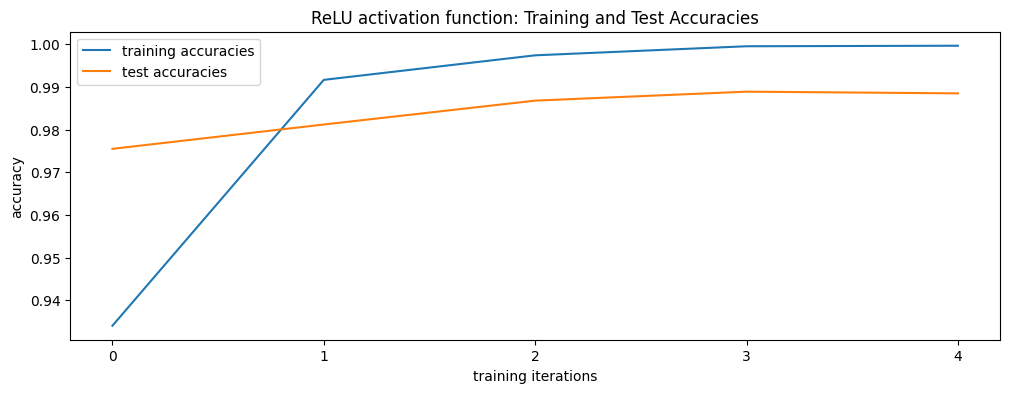

In [26]:
# For ReLU
# Initialize VGG11 model
act_func_name = "ReLU"
act_fun = CustomActivation(name=act_func_name)
network = VGG11(act_fun)
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

# # Train the model
# accuracy_train = []
# accuracy_val = []
# accuracy_test = []
# train_losses = []
# test_losses = []

for i in range(5):
    print(f"{i+1}th training iteration")
    k_fold_cross_validation()
    testing()


accuracy_train_relu = accuracy_train[:]
accuracy_val_relu = accuracy_val[:]
accuracy_test_relu = accuracy_test[:]
train_losses_relu = train_losses[:]
test_losses_relu = test_losses[:]


# print(accuracy_test)


plt.figure(figsize=(12,4))
plt.plot(accuracy_train_relu, label='training accuracies')
plt.plot(accuracy_test_relu, label='test accuracies')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('ReLU activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
[0.131400004029274, 0.1574999988079071, 0.5616000294685364, 0.6725000143051147, 0.8672000169754028]


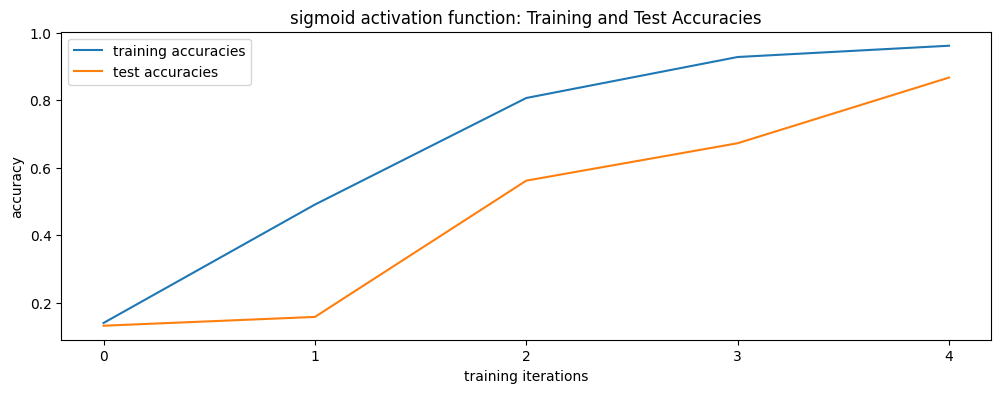

In [27]:
# For Sigmoid
# Initialize VGG11 model
act_fun = CustomActivation(name="Sigmoid")
network = VGG11(act_fun)
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

# Train the model
accuracy_train = []
accuracy_val = []
accuracy_test = []
train_losses = []
test_losses = []

for i in range(5):
    print(f"{i+1}th training iteration")
    k_fold_cross_validation()
    testing()

print(accuracy_test)

accuracy_train_sigmoid = accuracy_train[:]
accuracy_test_sigmoid = accuracy_test[:]
train_losses_sigmoid = train_losses[:]
test_losses_sigmoid = test_losses[:]

plt.figure(figsize=(12,4))
plt.plot(accuracy_train_sigmoid, label='training accuracies')
plt.plot(accuracy_test_sigmoid, label='test accuracies')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('sigmoid activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
[0.9412000179290771, 0.948199987411499, 0.95169997215271, 0.978600025177002, 0.9692000150680542]


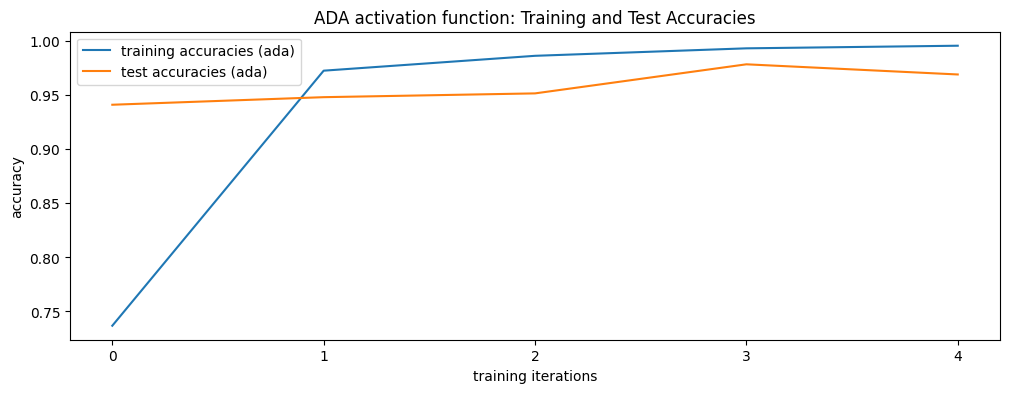

In [28]:
# For ADA
# Initialize VGG11 model
act_fun = CustomActivation(name="ADA")
network = VGG11(act_fun)
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

# Train the model
accuracy_train = []
accuracy_val = []
accuracy_test = []
train_losses = []
test_losses = []

for i in range(5):
    print(f"{i+1}th training iteration")
    k_fold_cross_validation()
    testing()
    
print(accuracy_test)

accuracy_train_ada = accuracy_train[:]
accuracy_val_ada = accuracy_val[:]
accuracy_test_ada = accuracy_test[:]
train_losses_ada = train_losses[:]
test_losses_ada = test_losses[:]


plt.figure(figsize=(12,4))
# plt.plot(accuracy_train_original, label='training accuracies')
# plt.plot(accuracy_test_original, label='test accuracies')
plt.plot(accuracy_train_ada, label='training accuracies (ada)')
plt.plot(accuracy_test_ada, label='test accuracies (ada)')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('ADA activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

1th training iteration
2th training iteration
3th training iteration
4th training iteration
5th training iteration
[0.8950999975204468, 0.9581000208854675, 0.9799000024795532, 0.9797999858856201, 0.9797000288963318]


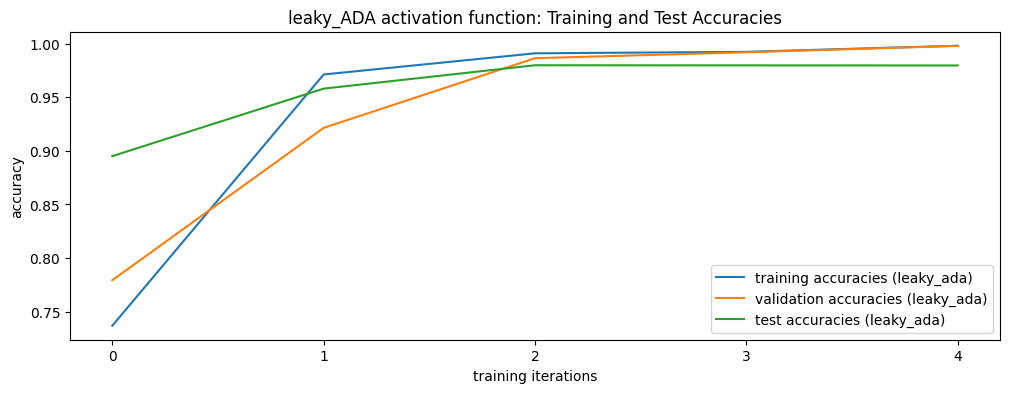

In [29]:
# For Leaky_ADA
# Initialize VGG11 model
act_fun = CustomActivation(name="Leaky_ADA")
network = VGG11(act_fun)
network.to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

# Train the model
accuracy_train = []
accuracy_val = []
accuracy_test = []
train_losses = []
test_losses = []

for i in range(5):
    print(f"{i+1}th training iteration")
    k_fold_cross_validation()
    testing()
    
print(accuracy_test)

accuracy_train_leaky_ada = accuracy_train[:]
accuracy_val_leaky_ada = accuracy_val[:]
accuracy_test_leaky_ada = accuracy_test[:]
train_losses_leaky_ada = train_losses[:]
test_losses_leaky_ada = test_losses[:]


plt.figure(figsize=(12,4))
plt.plot(accuracy_train_leaky_ada, label='training accuracies (leaky_ada)')
plt.plot(accuracy_val_leaky_ada, label='validation accuracies (leaky_ada)')
plt.plot(accuracy_test_leaky_ada, label='test accuracies (leaky_ada)')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('leaky_ADA activation function: Training and Test Accuracies')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()

## Comparison for all activations

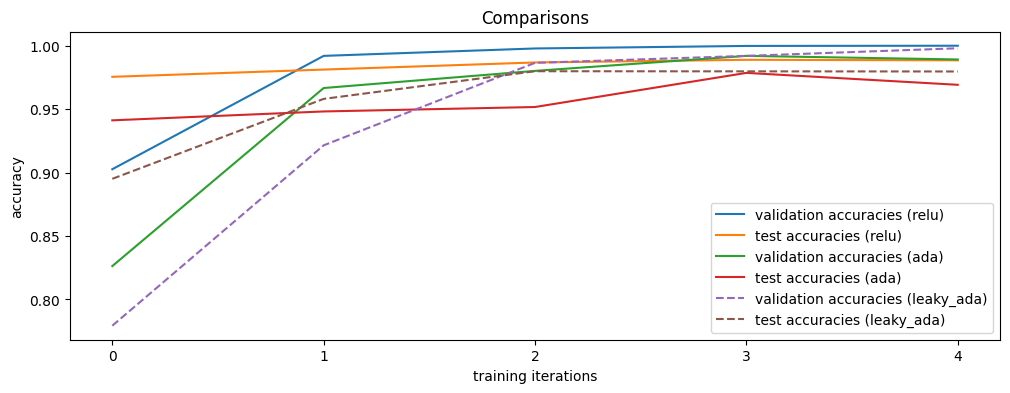

In [30]:
plt.figure(figsize=(12,4))
# plt.plot(accuracy_train_relu, label='training accuracies (relu)')
plt.plot(accuracy_val_relu, label='validation accuracies (relu)')
plt.plot(accuracy_test_relu, label='test accuracies (relu)')
# plt.plot(accuracy_train_ada, label='training accuracies (ada)')
plt.plot(accuracy_val_ada, label='validation accuracies (ada)')
plt.plot(accuracy_test_ada, label='test accuracies (ada)')
# plt.plot(accuracy_train_leaky_ada, label='training accuracies (leaky_ada)', linestyle='--')
plt.plot(accuracy_val_leaky_ada, label='validation accuracies (leaky_ada)', linestyle='--')
plt.plot(accuracy_test_leaky_ada, label='test accuracies (leaky_ada)', linestyle='--')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.title('Comparisons')
plt.xticks(np.arange(0, len(accuracy_train), 1))
plt.show()